In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from datetime import datetime

In [2]:
df = pd.read_csv('HUPA0001P.csv', delimiter=';')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').sort_index()

In [3]:
df['target_glucose'] = df['glucose'].shift(-3)

In [4]:
features = ['glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
            'bolus_volume_delivered', 'carb_input']

In [5]:
for lag in [1, 2, 3, 6]:
    df[f'glucose_lag_{lag}'] = df['glucose'].shift(lag)

In [6]:
df['glucose_rolling_mean_1h'] = df['glucose'].rolling(6).mean()
df['glucose_trend_1h'] = df['glucose'] - df['glucose'].shift(6)

In [7]:
df['hour'] = df.index.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

In [8]:
features.extend([f'glucose_lag_{lag}' for lag in [1, 2, 3, 6]])
features.extend(['glucose_rolling_mean_1h', 'glucose_trend_1h', 'hour_sin', 'hour_cos'])

In [9]:
df_clean = df[features + ['target_glucose']].dropna()

In [10]:
def create_sequences(data, features, target, sequence_length=12, prediction_horizon=3):
    """Create sequences for LSTM training"""
    X, y = [], []

    for i in range(sequence_length, len(data) - prediction_horizon):
        # Input: sequence of past data (2 hours for sequence_length=12)
        X.append(data[features].iloc[i-sequence_length:i].values)
        # Output: target value at prediction horizon (30 minutes ahead)
        y.append(data[target].iloc[i + prediction_horizon - 1])

    return np.array(X), np.array(y)

In [11]:
# Parameters
SEQUENCE_LENGTH = 12  # 2 hours of history (12 * 10min = 120min)
PREDICTION_HORIZON = 3  # 30 minutes ahead (3 * 10min = 30min)

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_clean.index)
scaled_df['target_glucose'] = df_clean['target_glucose'].values

# Create sequences
X, y = create_sequences(scaled_df, features, 'target_glucose', SEQUENCE_LENGTH, PREDICTION_HORIZON)

In [12]:
print(f"Sequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

Sequences shape: (4072, 12, 15)
Targets shape: (4072,)


In [13]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")

Training data: (3257, 12, 15)
Testing data: (815, 12, 15)


In [14]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        LSTM(32, return_sequences=True),
        Dropout(0.2),

        LSTM(16, return_sequences=False),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)  # Output: predicted glucose value
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,121 (145.00 KB)

 Trainable params: 37,121 (145.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training parameters
EPOCHS = 100
BATCH_SIZE = 32

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=10, factor=0.5)
]

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 35401.0547 - mae: 173.7071 - val_loss: 27009.9727 - val_mae: 152.2873 - learning_rate: 0.0010
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 15987.9277 - mae: 102.9165 - val_loss: 4222.7007 - val_mae: 52.4699 - learning_rate: 0.0010
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5624.2563 - mae: 58.1066 - val_loss: 4193.0400 - val_mae: 52.3664 - learning_rate: 0.0010
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5856.7388 - mae: 59.3923 - val_loss: 4285.1411 - val_mae: 52.6824 - learning_rate: 0.0010
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5823.2847 - mae: 58.6745 - val_loss: 3317.7400 - val_mae: 45.1010 - learning_rate: 0.0010
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3790.9229 - mae: 45.8610 - val_loss: 1457.9109 - val_mae: 29.7386 - learning_rate: 0.0010
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2102.3447 - mae: 34.

In [16]:
# Predictions
y_pred = model.predict(X_test).flatten()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Clinical accuracy: percentage within 20% of actual value
within_20_percent = np.mean(np.abs(y_test - y_pred) / y_test < 0.2) * 100
print(f"Within 20% of actual: {within_20_percent:.1f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
MAE: 23.01
RMSE: 30.98
R² Score: 0.7487
Within 20% of actual: 81.0%


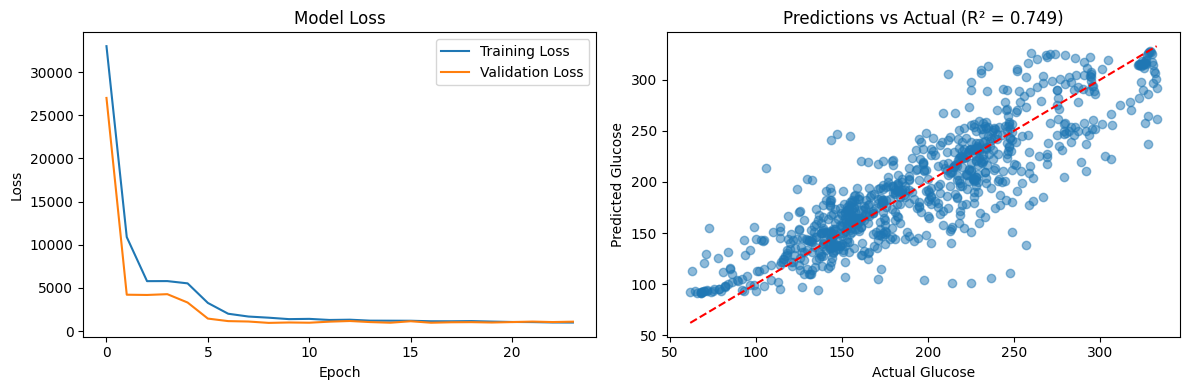

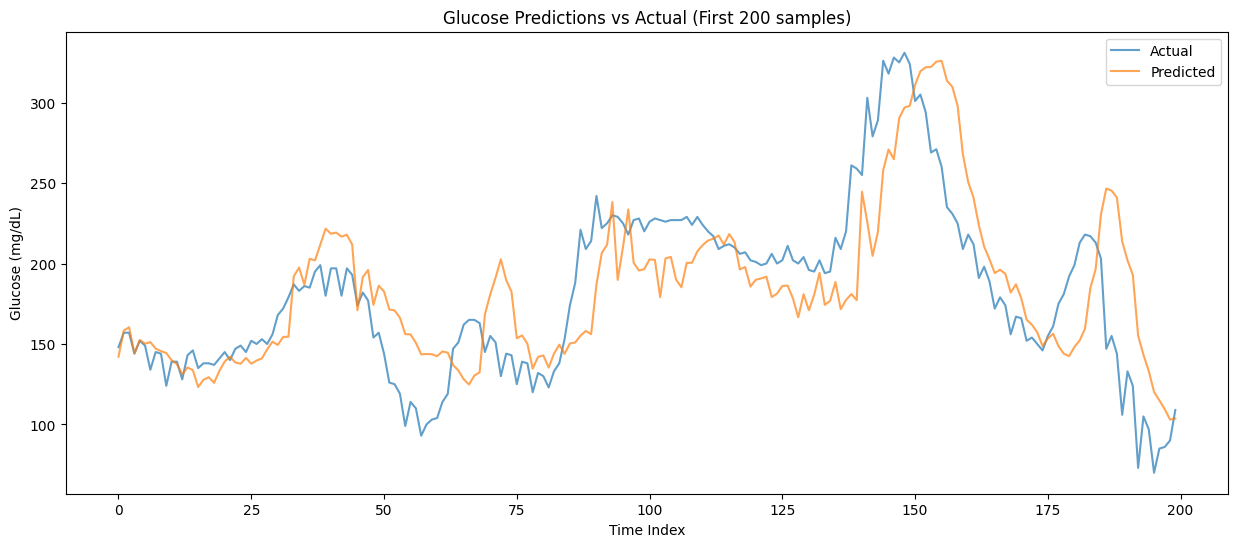

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Glucose')
plt.ylabel('Predicted Glucose')
plt.title(f'Predictions vs Actual (R² = {r2:.3f})')

plt.tight_layout()
plt.show()

# Plot time series of predictions
plt.figure(figsize=(15, 6))
plt.plot(y_test[:200], label='Actual', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.title('Glucose Predictions vs Actual (First 200 samples)')
plt.xlabel('Time Index')
plt.ylabel('Glucose (mg/dL)')
plt.legend()
plt.show()

In [18]:
def predict_future_glucose(model, last_sequence, scaler, features, steps=6):
    """Predict glucose for next hour (6 steps * 10min = 60min)"""
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0, 0]
        predictions.append(next_pred)

        # Update sequence for next prediction
        new_row = current_sequence[-1].copy()
        # Update glucose with prediction (you might want to update other features differently)
        glucose_idx = features.index('glucose')
        new_row[glucose_idx] = next_pred

        # Shift sequence and add new row
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return predictions

# Example usage
last_seq = X_test[-1]
future_predictions = predict_future_glucose(model, last_seq, scaler, features)
print(f"Next hour predictions: {future_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Next hour predictions: [np.float32(316.99655), np.float32(319.69556), np.float32(319.84106), np.float32(319.48047), np.float32(318.67484), np.float32(317.3775)]


In [20]:
model.save('glucose_lstm_model.h5')
print("✅ Model saved as 'glucose_lstm_model.h5'")

✅ Model saved as 'glucose_lstm_model.h5'
